In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import act

Read data

In [24]:
file_path = glob.glob('/Users/bhupendra/projects/crocus/data/cl61/cl61-correct-time/cmscl6001_20230801*.nc')
ds= xr.open_mfdataset(file_path, combine='by_coords', parallel=True, chunks={"time": 100})
ds

<xarray.Dataset> Size: 95MB
Dimensions:                            (time: 1440, layer: 5, range: 3276)
Coordinates:
  * time                               (time) datetime64[ns] 12kB 2023-07-31T...
  * range                              (range) float64 26kB 0.0 ... 1.572e+04
  * layer                              (layer) float64 40B 1.0 2.0 3.0 4.0 5.0
    longitude                          float64 8B -87.72
    latitude                           float64 8B 41.98
Data variables: (12/26)
    cloud_base_heights                 (time, layer) float64 58kB dask.array<chunksize=(5, 5), meta=np.ndarray>
    vertical_visibility                (time) float64 12kB dask.array<chunksize=(5,), meta=np.ndarray>
    p_pol                              (time, range) float32 19MB dask.array<chunksize=(5, 3276), meta=np.ndarray>
    x_pol                              (time, range) float32 19MB dask.array<chunksize=(5, 3276), meta=np.ndarray>
    beta_att                           (time, range) float32 19MB dask.array<chunksize=(5, 3276), meta=np.ndarray>
    linear_depol_ratio                 (time, range) float32 19MB dask.array<chunksize=(5, 3276), meta=np.ndarray>
    ...                                 ...
    fog_detection                      (time) float32 6kB dask.array<chunksize=(5,), meta=np.ndarray>
    receiver_gain                      (time) float32 6kB dask.array<chunksize=(5,), meta=np.ndarray>
    range_resolution                   (time) float32 6kB 4.8 4.8 ... 4.8 4.8
    cloud_calibration_factor           (time) float64 12kB 0.4334 ... 0.4334
    cloud_calibration_factor_user      (time) float64 12kB 0.4334 ... 0.4334
    overlap_function                   (time, range) float32 19MB dask.array<chunksize=(5, 3276), meta=np.ndarray>
Attributes: (12/14)
    title:                          CL61D CL61 with Depolarization
    institution:                    NEIU
    source:                         
    conventions:                    CF-1.8
    schema_version:                 1.3
    sw_version:                     1.2.7
    ...                             ...
    unit:                           m
    instrument_serial_number:       U3810828
    overlap_function_provided:      1
    overlap_is_corrected:           1
    file_temporal_span_in_minutes:  5.0
    profile_interval_in_seconds:    60

In [3]:
f'CL61_plot_{str(ds['time'].values[-1])}.png'

'CL61_plot_2023-08-01T23:54:50.857000192.png'

### Correct using ACT for better plotting

In [4]:
variables=['beta_att', 'p_pol', 'x_pol']
for var in variables:
    if var != 'linear_depol_ratio':
        ds = act.corrections.correct_ceil(ds, var_name=var)

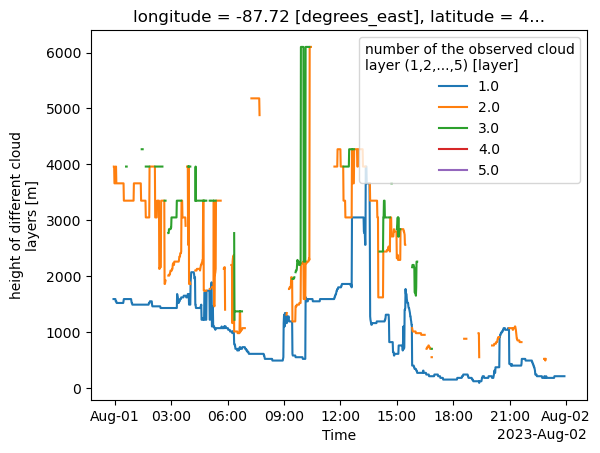

In [5]:
ds['sky_condition_cloud_layer_heights'].plot.line(x='time')
# Function to plot cloud layers on a given axis
def plot_cloud_layers(ax, time_slice):
    cloud_heights = ds['sky_condition_cloud_layer_heights'].isel().values
    for i, height in enumerate(cloud_heights.T):
        if i < len(colors):  # Ensure we don't exceed the number of defined colors
            ax.plot(ds['time'], height, color=colors[i], linestyle='-', linewidth=2, label=f'Layer {i + 1}')
    ax.legend()

In [6]:

# for plotting, it is better
ds = ds.assign(range_km=ds['range'] / 1000)
ds= ds.assign(sky_condition_cloud_layer_heights_km = ds['sky_condition_cloud_layer_heights']/1000)
ds['range_km'].attrs['units'] = 'km' 
ds = ds.swap_dims({'range': 'range_km'})


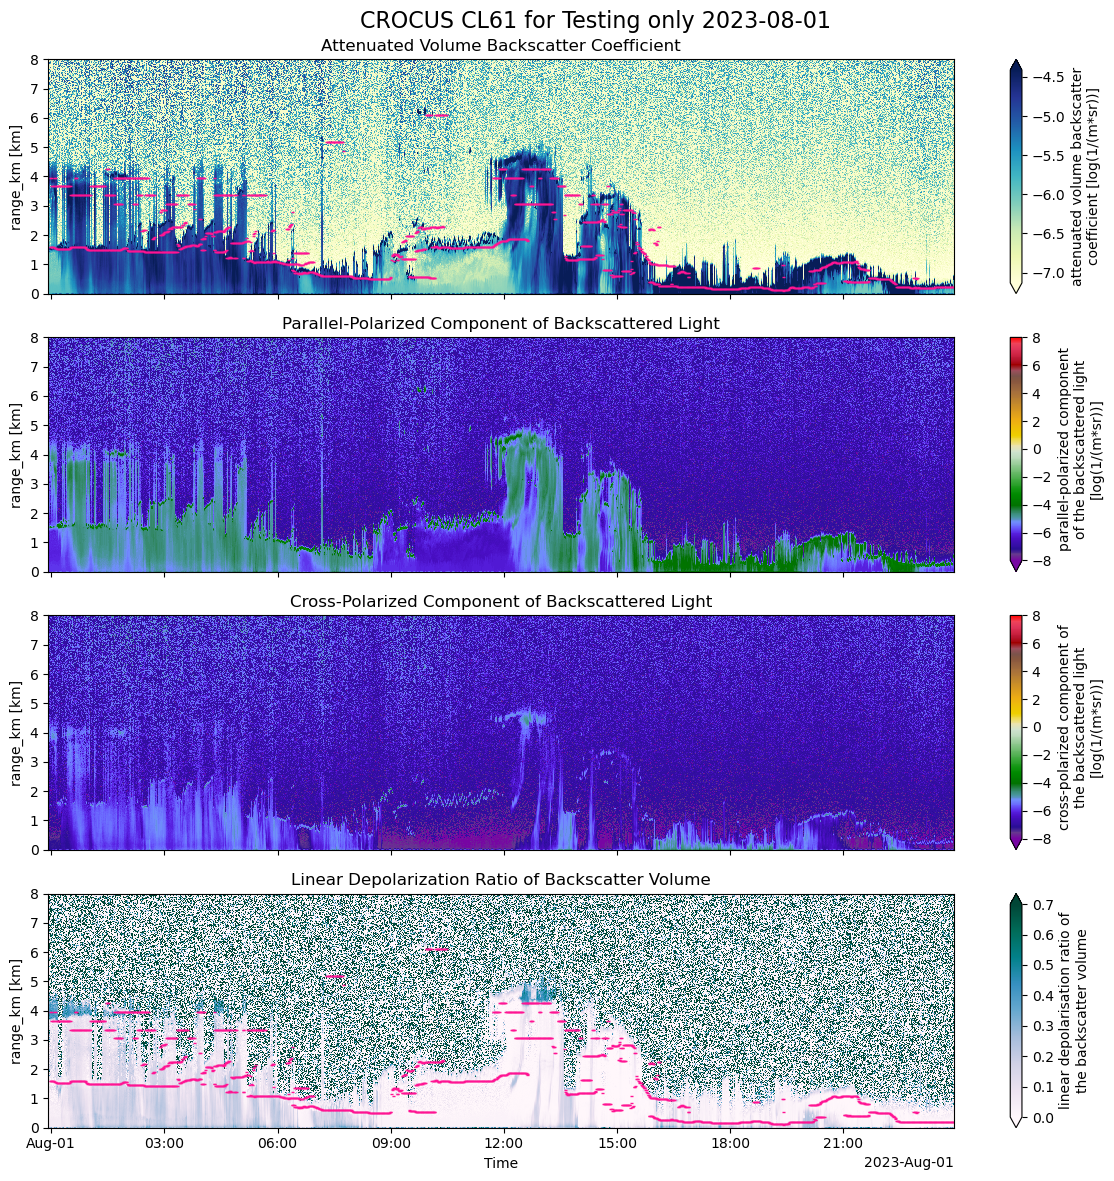

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 12), sharex=True)
ylim = (0, 8)
date_title = f"CROCUS CL61 for Testing only {np.datetime_as_string(ds['time'].values[100], unit='D')}"
fig.suptitle(date_title, fontsize=16)

# Plot p_pol
ds['p_pol'].plot(ax=axes[1], x='time', y='range_km', cmap='Carbone42', robust=True, vmin=-8, vmax=8)
axes[1].set_title('Parallel-Polarized Component of Backscattered Light')
axes[1].set_xlabel('')
axes[1].set_ylim(ylim)

# Plot x_pol
ds['x_pol'].plot(ax=axes[2], x='time', y='range_km', cmap='Carbone42', robust=True, vmin=-8, vmax=8)
axes[2].set_title('Cross-Polarized Component of Backscattered Light')
axes[2].set_xlabel('')
axes[2].set_ylim(ylim)

# Plot
ds['beta_att'].plot(ax=axes[0], x='time', y='range_km', cmap='YlGnBu', robust=True)#, vmin=0)
plot_cloud_heights(axes[0], ds, color='deeppink')
axes[0].set_title('Attenuated Volume Backscatter Coefficient')
axes[0].set_xlabel('')
axes[0].set_ylim(ylim)

# Plot
ds['linear_depol_ratio'].plot(ax=axes[3], x='time', y='range_km', cmap='PuBuGn', vmin=0, vmax=0.7, robust=True)
plot_cloud_heights(axes[3], ds, color='deeppink')
axes[3].set_title('Linear Depolarization Ratio of Backscatter Volume')
axes[3].set_ylim(ylim)

plt.tight_layout()
plt.show()

In [21]:
def plot_cloud_heights(ax, ds, color='black'):
    """
    Plots cloud layer heights as small white '~' scatter markers.
    """
    if 'sky_condition_cloud_layer_heights_km' not in ds:
        return

    cloud_heights = ds['sky_condition_cloud_layer_heights_km'].values
    times = ds['time'].values

    # Flatten if it's a 2D array: (time, layers)
    if len(cloud_heights.shape) == 2:
        times = np.repeat(times, cloud_heights.shape[1])
        heights = cloud_heights.flatten()
    else:
        heights = cloud_heights
        times = np.tile(times, 1)

    # Filter valid points
    mask = ~np.isnan(heights)
    ax.scatter(
        times[mask],
        heights[mask],
        marker=1,
        c=color,
        s=5,
        linewidths=1
    )

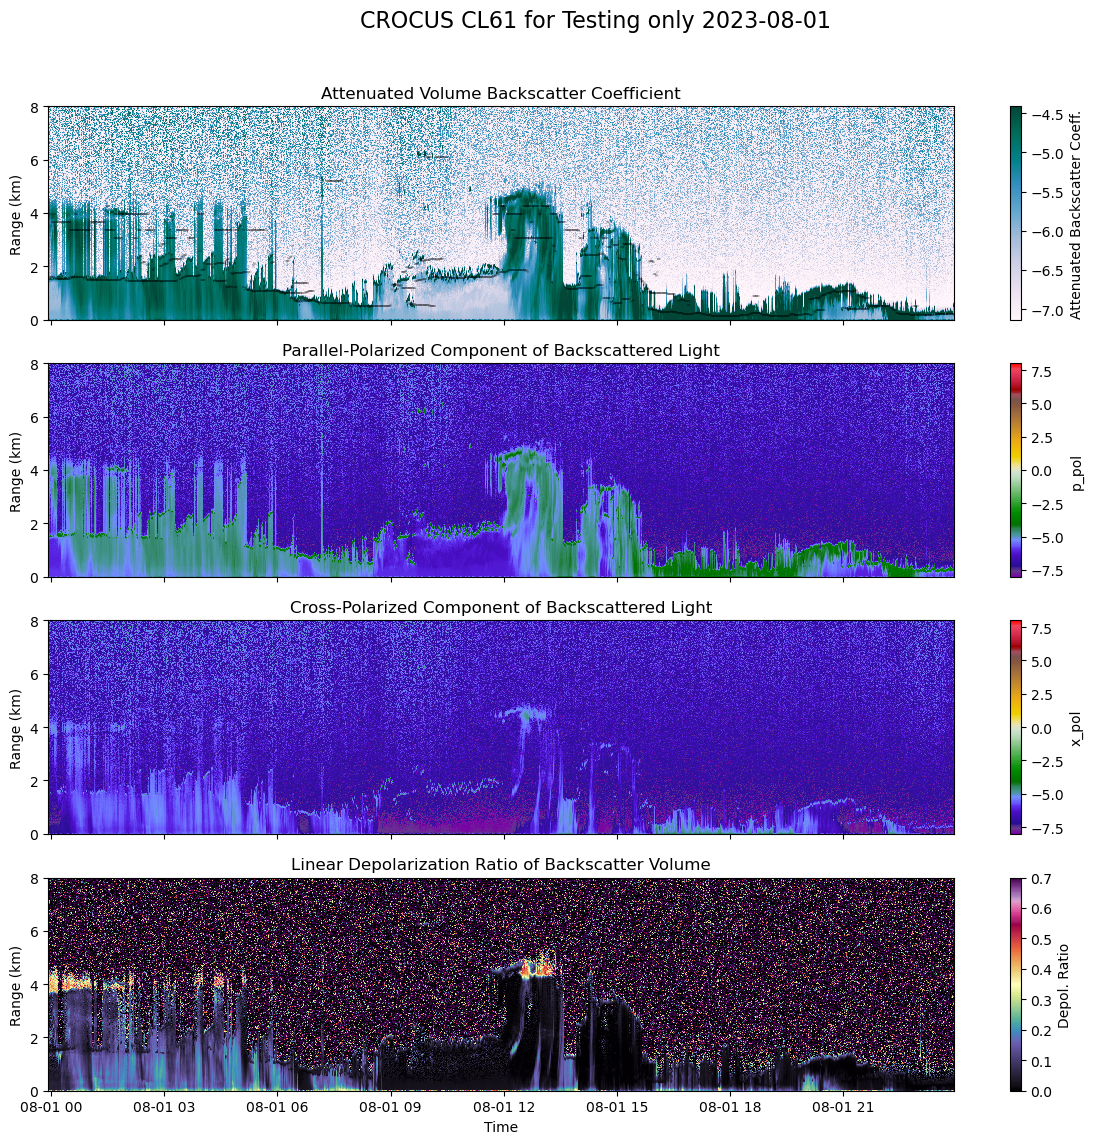

In [12]:
import matplotlib.pyplot as plt
import numpy as np
# Assume 'ds' is your loaded xarray Dataset
# Assume 'plot_cloud_heights' is a defined function:
# def plot_cloud_heights(ax, data_source):
#    # ... plotting logic ...
#    pass

# --- Setup ---
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 12), sharex=True)
ylim = (0, 8)
# Use a specific index or logic to select the date for the title
# Using index 100 as in the original example
try:
    date_str = np.datetime_as_string(ds['time'].values[100], unit='D')
except IndexError:
    # Handle cases where there might not be 100 time steps
    date_str = np.datetime_as_string(ds['time'].values[0], unit='D') if len(ds['time']) > 0 else "Unknown Date"

date_title = f"CROCUS CL61 for Testing only {date_str}"
fig.suptitle(date_title, fontsize=16)

# --- Extract common coordinates ---
# Ensure time and range are 1D arrays for pcolormesh
time_coords = ds['time'].values
range_coords = ds['range_km'].values

# --- Plot beta_att (axes[0]) ---
data_beta = ds['beta_att'].values
# Handle 'robust=True' manually: calculate 2nd and 98th percentiles
vmin_beta, vmax_beta = np.nanpercentile(data_beta, [2, 98])
# pcolormesh expects Z[y, x], but xarray often stores as [time, range] -> [x, y]
# So we need to transpose the data array (data_beta.T)
im0 = axes[0].pcolormesh(time_coords, range_coords, data_beta.T,
                         cmap='PuBuGn',
                         vmin=vmin_beta, vmax=vmax_beta,
                         shading='auto') # 'auto' or 'nearest' often work well
fig.colorbar(im0, ax=axes[0], label='Attenuated Backscatter Coeff.')
plot_cloud_heights(axes[0], ds) # Call the cloud height plotting function
axes[0].set_title('Attenuated Volume Backscatter Coefficient')
axes[0].set_ylabel('Range (km)') # Add y-label for clarity
axes[0].set_ylim(ylim)

# --- Plot p_pol (axes[1]) ---
data_ppol = ds['p_pol'].values
# Robust is True, but vmin/vmax are also specified. We prioritize vmin/vmax.
# No need to calculate percentiles here.
im1 = axes[1].pcolormesh(time_coords, range_coords, data_ppol.T,
                         cmap='Carbone42',
                         vmin=-8, vmax=8,
                         shading='auto')
fig.colorbar(im1, ax=axes[1], label='p_pol')
axes[1].set_title('Parallel-Polarized Component of Backscattered Light')
axes[1].set_ylabel('Range (km)')
axes[1].set_ylim(ylim)

# --- Plot x_pol (axes[2]) ---
data_xpol = ds['x_pol'].values
# Robust is True, but vmin/vmax are also specified. We prioritize vmin/vmax.
im2 = axes[2].pcolormesh(time_coords, range_coords, data_xpol.T,
                         cmap='Carbone42',
                         vmin=-8, vmax=8,
                         shading='auto')
fig.colorbar(im2, ax=axes[2], label='x_pol')
axes[2].set_title('Cross-Polarized Component of Backscattered Light')
axes[2].set_ylabel('Range (km)')
axes[2].set_ylim(ylim)

# --- Plot linear_depol_ratio (axes[3]) ---
data_ldr = ds['linear_depol_ratio'].values
# Robust is True, but vmin/vmax are also specified. We prioritize vmin/vmax.
im3 = axes[3].pcolormesh(time_coords, range_coords, data_ldr.T,
                         cmap='ChaseSpectral',
                         vmin=0, vmax=0.7,
                         shading='auto')
fig.colorbar(im3, ax=axes[3], label='Depol. Ratio')
axes[3].set_title('Linear Depolarization Ratio of Backscatter Volume')
axes[3].set_ylabel('Range (km)')
axes[3].set_xlabel('Time') # Add x-label to the bottom plot
axes[3].set_ylim(ylim)

# --- Final Adjustments ---
# Improve spacing between subplots and title
fig.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust rect to prevent title overlap
plt.show()